In [14]:
%run 00_Dataset.ipynb

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import array
import math
import pandas as pd
#from astropy.cosmology import FlatLambdaCDM
import matplotlib
from matplotlib import gridspec

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [16]:
# create a new FlatLambdaCDM object with arguments giving the Hubble parameter and Omega matter (both at z=0)
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [21]:
if dataset == 'Pantheon':
    skip_header = 6
else :
    skip_header = 0
    
data = (np.genfromtxt(
    in_filepath,
    skip_header=skip_header, 
    names=True,
    comments='#')
)

data = pd.DataFrame(data)

data = data.sort_values('zCMB')

In [24]:
z = data['zCMB'].astype(float)
mu = data['MU'].astype(float)
mu_err = data['MUERR'].astype(float)
#idsurvey = data['IDSURVEY'].astype(float) 

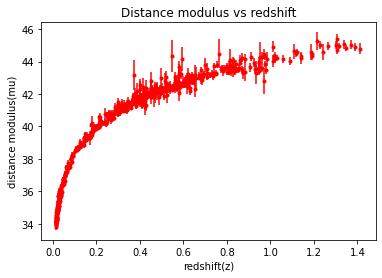

<Figure size 432x288 with 0 Axes>

In [25]:
plt.errorbar(z, mu, yerr=mu_err, fmt='.r');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
plt.title('Distance modulus vs redshift')
plt.show()

plt.savefig(os.path.join(out_dir,'01_DistanceModulus_vs_Redshift_'+dataset+'.png'))

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
z_train, z_val, mu_train, mu_val = train_test_split(z, mu, test_size=0.2, random_state=0)

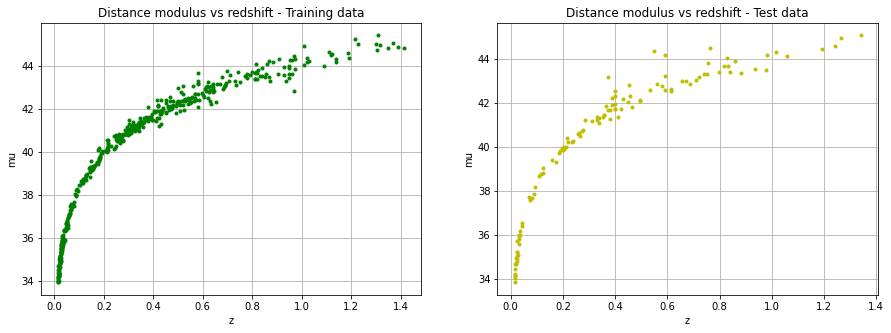

<Figure size 432x288 with 0 Axes>

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(z_train, mu_train, '.g')
ax1.set_ylabel('mu')
ax1.set_xlabel('z')
ax1.set_title('Distance modulus vs redshift - Training data')
ax1.grid(True)

ax2.plot(z_val, mu_val, '.y')
ax2.set_ylabel('mu')
ax2.set_xlabel('z')
ax2.set_title('Distance modulus vs redshift - Test data')
ax2.grid(True)

plt.show()

plt.savefig(os.path.join(out_dir,'02_Train-Test-Split.png'))

In [29]:
# prepare sequential data
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

In [30]:
window_size = 4
train_stride = 1

z_strided = strided_app(z.to_numpy(), window_size, train_stride)
mu_strided = strided_app(mu.to_numpy(), window_size, train_stride)

z_train, z_val, mu_train, mu_val = train_test_split(z_strided, mu_strided, test_size=0.2, random_state=0)

In [31]:
z_train = np.expand_dims(z_train, axis=-1)
#z_test = np.expand_dims(z_test, axis=-1)
z_val = np.expand_dims(z_val, axis=-1)
mu_train = np.expand_dims(mu_train, axis=-1)
#mu_test = np.expand_dims(mu_test, axis=-1)
mu_val = np.expand_dims(mu_val, axis=-1)